In [53]:
import torchvision
import  torch
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from  torch import  nn,optim,cuda,from_numpy
from torch.utils import  data
from  torchvision import  datasets,transforms
import  torch.nn.functional as F
import matplotlib.pyplot as plt
import  numpy as np
import  cv2

In [69]:
device ='cpu' if cuda.is_available() else 'cuda'
print(device)

cpu


In [70]:
b_size = 64
train_dataset = datasets.CIFAR100(root="data/",transform = ToTensor(), download = True)

test_dataset = datasets.CIFAR100(root = "data/",transform = ToTensor(),  train = False)

train_data = data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_data = data.DataLoader(test_dataset, batch_size=b_size, shuffle=False)



Files already downloaded and verified


In [71]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [72]:
classes = train_dataset.classes 
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 100
Class Names :
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

In [73]:
img,label =train_dataset[32]
img_shape=img.shape
img_shape

torch.Size([3, 32, 32])

Label as Number: 47
Label as Name: maple_tree


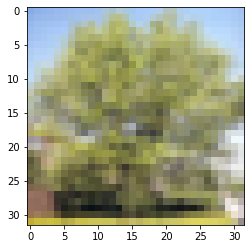

In [74]:
img, label =train_dataset[32]
plt.imshow(img.permute((1,2,0)))
print('Label as Number:', label)
print('Label as Name:', classes[label])

In [86]:
# Filterlash
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128,3),
            nn.ReLU(),
            nn.Conv2d(128, 128,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #  128 x 8 x 8
            nn.BatchNorm2d(128),

            
            nn.Flatten(), 
            nn.Linear(128*5*5, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100))
        
    def forward(self, xb):
        return self.network(xb)


model = Cifar10CnnModel()
model.to(device)


Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=3200, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=256, bias=True)
    (16): ReLU()
    (17): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [87]:
criterion = nn.CrossEntropyLoss()
optimize = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


def train(epoch):
    model.train()
    for b_i, data_ in enumerate(train_data):
        data_, label = data_[0].to(device), data_[1].to(device)
        optimize.zero_grad()
        predict = model(data_)
        fault = criterion(predict, label)
        fault.backward()
        optimize.step()

        if b_i % 10 == 0:
            print(f"Epoch - {epoch + 1} | Batch - {b_i} {b_i * len(data_)}/{len(train_data.dataset)} \
            | Loss: {fault.item()}")


def test():
    model.eval()
    Fault = 0
    Right = 0
    for img, label in test_data:
        img, label = img.to(device), label.to(device)
        predict = model(img)
        Fault += criterion(predict, label).item()
        result = predict.data.max(1, keepdim=True)[1]
        Right += result.eq(label.data.view_as(result)).cpu().sum()
    Fault /= (len(test_data.dataset))
    print(f"Aniqlik : {Right / len(test_data.dataset)}, Foizda {100.0 * Right / len(test_data.dataset)}%")


for epoch in range(10):
    train(epoch)
    test()


Epoch - 1 | Batch - 0 0/50000             | Loss: 4.599460601806641
Epoch - 1 | Batch - 10 640/50000             | Loss: 4.599660873413086
Epoch - 1 | Batch - 20 1280/50000             | Loss: 4.5966105461120605
Epoch - 1 | Batch - 30 1920/50000             | Loss: 4.569420337677002
Epoch - 1 | Batch - 40 2560/50000             | Loss: 4.506649494171143
Epoch - 1 | Batch - 50 3200/50000             | Loss: 4.3570966720581055
Epoch - 1 | Batch - 60 3840/50000             | Loss: 4.443273067474365
Epoch - 1 | Batch - 70 4480/50000             | Loss: 4.308671474456787
Epoch - 1 | Batch - 80 5120/50000             | Loss: 4.422155380249023
Epoch - 1 | Batch - 90 5760/50000             | Loss: 4.080687999725342
Epoch - 1 | Batch - 100 6400/50000             | Loss: 4.2434468269348145
Epoch - 1 | Batch - 110 7040/50000             | Loss: 4.317813873291016
Epoch - 1 | Batch - 120 7680/50000             | Loss: 4.080372333526611
Epoch - 1 | Batch - 130 8320/50000             | Loss: 3.943454

Epoch - 2 | Batch - 320 20480/50000             | Loss: 2.8139612674713135
Epoch - 2 | Batch - 330 21120/50000             | Loss: 2.7735116481781006
Epoch - 2 | Batch - 340 21760/50000             | Loss: 2.8433213233947754
Epoch - 2 | Batch - 350 22400/50000             | Loss: 2.4956512451171875
Epoch - 2 | Batch - 360 23040/50000             | Loss: 2.4552807807922363
Epoch - 2 | Batch - 370 23680/50000             | Loss: 2.331909656524658
Epoch - 2 | Batch - 380 24320/50000             | Loss: 2.512829542160034
Epoch - 2 | Batch - 390 24960/50000             | Loss: 2.822091579437256
Epoch - 2 | Batch - 400 25600/50000             | Loss: 2.321540355682373
Epoch - 2 | Batch - 410 26240/50000             | Loss: 2.351956844329834
Epoch - 2 | Batch - 420 26880/50000             | Loss: 2.5061583518981934
Epoch - 2 | Batch - 430 27520/50000             | Loss: 2.6250596046447754
Epoch - 2 | Batch - 440 28160/50000             | Loss: 2.327880620956421
Epoch - 2 | Batch - 450 28800/5

Epoch - 3 | Batch - 630 40320/50000             | Loss: 1.927966833114624
Epoch - 3 | Batch - 640 40960/50000             | Loss: 2.4277169704437256
Epoch - 3 | Batch - 650 41600/50000             | Loss: 2.077622652053833
Epoch - 3 | Batch - 660 42240/50000             | Loss: 1.870177984237671
Epoch - 3 | Batch - 670 42880/50000             | Loss: 1.8779046535491943
Epoch - 3 | Batch - 680 43520/50000             | Loss: 2.3436498641967773
Epoch - 3 | Batch - 690 44160/50000             | Loss: 2.5202603340148926
Epoch - 3 | Batch - 700 44800/50000             | Loss: 1.8829412460327148
Epoch - 3 | Batch - 710 45440/50000             | Loss: 1.8396602869033813
Epoch - 3 | Batch - 720 46080/50000             | Loss: 1.6838430166244507
Epoch - 3 | Batch - 730 46720/50000             | Loss: 2.0083792209625244
Epoch - 3 | Batch - 740 47360/50000             | Loss: 1.8797990083694458
Epoch - 3 | Batch - 750 48000/50000             | Loss: 1.9421862363815308
Epoch - 3 | Batch - 760 4864

Epoch - 5 | Batch - 140 8960/50000             | Loss: 0.9074652791023254
Epoch - 5 | Batch - 150 9600/50000             | Loss: 1.263224720954895
Epoch - 5 | Batch - 160 10240/50000             | Loss: 1.0315062999725342
Epoch - 5 | Batch - 170 10880/50000             | Loss: 1.1852995157241821
Epoch - 5 | Batch - 180 11520/50000             | Loss: 1.1145970821380615
Epoch - 5 | Batch - 190 12160/50000             | Loss: 1.167459487915039
Epoch - 5 | Batch - 200 12800/50000             | Loss: 1.0753459930419922
Epoch - 5 | Batch - 210 13440/50000             | Loss: 1.1153736114501953
Epoch - 5 | Batch - 220 14080/50000             | Loss: 1.4821839332580566
Epoch - 5 | Batch - 230 14720/50000             | Loss: 1.1153522729873657
Epoch - 5 | Batch - 240 15360/50000             | Loss: 0.9500243067741394
Epoch - 5 | Batch - 250 16000/50000             | Loss: 1.1911174058914185
Epoch - 5 | Batch - 260 16640/50000             | Loss: 1.6839120388031006
Epoch - 5 | Batch - 270 17280

Epoch - 6 | Batch - 450 28800/50000             | Loss: 0.7514688372612
Epoch - 6 | Batch - 460 29440/50000             | Loss: 0.8216251134872437
Epoch - 6 | Batch - 470 30080/50000             | Loss: 0.6696997880935669
Epoch - 6 | Batch - 480 30720/50000             | Loss: 0.9517384767532349
Epoch - 6 | Batch - 490 31360/50000             | Loss: 0.6441131830215454
Epoch - 6 | Batch - 500 32000/50000             | Loss: 0.8327984809875488
Epoch - 6 | Batch - 510 32640/50000             | Loss: 0.6680939793586731
Epoch - 6 | Batch - 520 33280/50000             | Loss: 1.0240882635116577
Epoch - 6 | Batch - 530 33920/50000             | Loss: 0.9865024089813232
Epoch - 6 | Batch - 540 34560/50000             | Loss: 0.5621485710144043
Epoch - 6 | Batch - 550 35200/50000             | Loss: 0.7584925889968872
Epoch - 6 | Batch - 560 35840/50000             | Loss: 1.0502288341522217
Epoch - 6 | Batch - 570 36480/50000             | Loss: 0.8505780100822449
Epoch - 6 | Batch - 580 3712

Epoch - 7 | Batch - 750 48000/50000             | Loss: 0.6380643844604492
Epoch - 7 | Batch - 760 48640/50000             | Loss: 0.8153800368309021
Epoch - 7 | Batch - 770 49280/50000             | Loss: 1.0829057693481445
Epoch - 7 | Batch - 780 49920/50000             | Loss: 0.8129721283912659
Aniqlik : 0.4377000033855438, Foizda 43.77000045776367%
Epoch - 8 | Batch - 0 0/50000             | Loss: 0.40730583667755127
Epoch - 8 | Batch - 10 640/50000             | Loss: 0.5403522253036499
Epoch - 8 | Batch - 20 1280/50000             | Loss: 0.3197001516819
Epoch - 8 | Batch - 30 1920/50000             | Loss: 0.46530723571777344
Epoch - 8 | Batch - 40 2560/50000             | Loss: 0.3499062657356262
Epoch - 8 | Batch - 50 3200/50000             | Loss: 0.40287989377975464
Epoch - 8 | Batch - 60 3840/50000             | Loss: 0.312620609998703
Epoch - 8 | Batch - 70 4480/50000             | Loss: 0.4351383149623871
Epoch - 8 | Batch - 80 5120/50000             | Loss: 0.2132813781

Epoch - 9 | Batch - 260 16640/50000             | Loss: 0.20098526775836945
Epoch - 9 | Batch - 270 17280/50000             | Loss: 0.14866256713867188
Epoch - 9 | Batch - 280 17920/50000             | Loss: 0.16305182874202728
Epoch - 9 | Batch - 290 18560/50000             | Loss: 0.2779091000556946
Epoch - 9 | Batch - 300 19200/50000             | Loss: 0.18633684515953064
Epoch - 9 | Batch - 310 19840/50000             | Loss: 0.183058500289917
Epoch - 9 | Batch - 320 20480/50000             | Loss: 0.26359567046165466
Epoch - 9 | Batch - 330 21120/50000             | Loss: 0.2377045899629593
Epoch - 9 | Batch - 340 21760/50000             | Loss: 0.27829837799072266
Epoch - 9 | Batch - 350 22400/50000             | Loss: 0.15148837864398956
Epoch - 9 | Batch - 360 23040/50000             | Loss: 0.40136590600013733
Epoch - 9 | Batch - 370 23680/50000             | Loss: 0.1293550431728363
Epoch - 9 | Batch - 380 24320/50000             | Loss: 0.30762654542922974
Epoch - 9 | Batch

Epoch - 10 | Batch - 550 35200/50000             | Loss: 0.1839873045682907
Epoch - 10 | Batch - 560 35840/50000             | Loss: 0.44923579692840576
Epoch - 10 | Batch - 570 36480/50000             | Loss: 0.23232513666152954
Epoch - 10 | Batch - 580 37120/50000             | Loss: 0.2670150101184845
Epoch - 10 | Batch - 590 37760/50000             | Loss: 0.25084346532821655
Epoch - 10 | Batch - 600 38400/50000             | Loss: 0.27692893147468567
Epoch - 10 | Batch - 610 39040/50000             | Loss: 0.37575650215148926
Epoch - 10 | Batch - 620 39680/50000             | Loss: 0.15272536873817444
Epoch - 10 | Batch - 630 40320/50000             | Loss: 0.3752497434616089
Epoch - 10 | Batch - 640 40960/50000             | Loss: 0.2729493975639343
Epoch - 10 | Batch - 650 41600/50000             | Loss: 0.11223411560058594
Epoch - 10 | Batch - 660 42240/50000             | Loss: 0.13954009115695953
Epoch - 10 | Batch - 670 42880/50000             | Loss: 0.12446995079517365
Epo

In [88]:
torch.save(model.state_dict(),'Cifar100.h5')

In [90]:
model.load_state_dict(torch.load('Cifar100.h5'))
model.eval()

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=3200, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=256, bias=True)
    (16): ReLU()
    (17): Linear(in_features=256, out_features=100, bias=True)
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


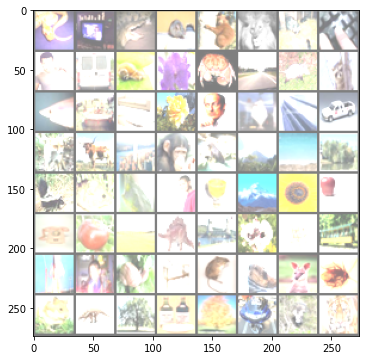

Predict : snake  television  crocodile  mouse   bear   lion  raccoon  keyboard    man    bus  snail  orchid   crab   road  possum  raccoon  shark   tank  couch   rose    man  flatfish  skyscraper  pickup_truck    fox  cattle  skyscraper  chimpanzee   seal  mountain    sea  willow_tree  skunk  mouse  caterpillar    boy    cup  mountain  sunflower  apple  telephone  apple  plain  dinosaur  bridge  poppy  chair  train  rocket   girl  snail  chair  mouse  beaver  kangaroo  cockroach  hamster  dinosaur  oak_tree  bottle  maple_tree  motorcycle  skunk  tiger 


In [91]:
classes = train_dataset.classes 
def imshow(img):
    plt.figure(figsize=(8,6))
    img = img / 1 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


dataiter = iter(train_data)
images, labels = dataiter.next()


imshow(torchvision.utils.make_grid(images))
print('Predict :',' '.join('%5s ' % classes[labels[j]] for j in range(b_size)))


In [ ]:
Cifar100 : 44.61%
Dog_Cat classifier : 77.01433563232422%
FashionMnist : 90.91000366210938%
K-Mnist : 94.5%
